In [47]:
# IMPORTS
from collections import namedtuple
import re
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [49]:
GapSentence = namedtuple('GapSentence', ['sen', 'raw', 'labels', 'filler', 'gap_start', 'gap_end', 'dep_len'])


def read_data(filename, skip_lastline=True):
    with open(filename) as f:
        stringsens = f.read().split('\n')
        wordsens = [s.split(' ') for s in stringsens]
        if skip_lastline:
            wordsens = wordsens[:-1]
    return wordsens

def locate_gap(s):
    sen = []
    rawsen = ' '.join(s)
    labels = []
    filler = None
    gap_start = None
    gap_end = None
    dep_len = None
    
    sen_len = 0
    inside_gap = False
    for i, w in enumerate(s):
        if re.match(r'(\*T\*-[0-9]+)|(</?fgdep>)', w) is None:
            sen.append(w)
            sen_len += 1
            
            if inside_gap:
                labels.append(1)
            else:
                labels.append(0)

        elif w == '<fgdep>':
            inside_gap = True
            gap_start = sen_len
            filler = s[i+1]

        elif w == '</fgdep>':
            inside_gap = False
            gap_end = sen_len
            dep_len = gap_end - gap_start
    
    return GapSentence(sen, rawsen, labels, filler, gap_start, gap_end, dep_len)


rawsens = read_data('data/filler_gap_deps.txt')
gapsens = {i:g for i,g in enumerate(map(locate_gap, rawsens))}

whgapsens = {i:g for i,g in gapsens.items() if g.filler in 'Ww' and g.dep_len > 2}

print(len(whgapsens))

with open('data/gapsens.pickle', 'wb') as f:
    pickle.dump(gapsens, f)

In [63]:
def print_gapsen(g):
    print(f'{g.raw}\n')
    for i, x in enumerate(zip(g.sen,g.labels)):
        sym = 'f-' if i==g.gap_start else 'g-' if i==g.gap_end else '  '
        space1 = ' '*((i<10)+1)
        space2 = ' '*(15-len(x[0]))
        print(f'{sym}{i}:{space1}{x[0]}{space2}{x[1]}')
        
print_gapsen(gapsens[2])

Neither Lorillard nor the researchers <fgdep> who *T*-3 </fgdep> studied the workers were aware of any research on smokers of the Kent cigarettes .

  0:  Neither        0
  1:  Lorillard      0
  2:  nor            0
  3:  the            0
  4:  researchers    0
f-5:  who            1
g-6:  studied        0
  7:  the            0
  8:  workers        0
  9:  were           0
  10: aware          0
  11: of             0
  12: any            0
  13: research       0
  14: on             0
  15: smokers        0
  16: of             0
  17: the            0
  18: Kent           0
  19: cigarettes     0
  20: .              0


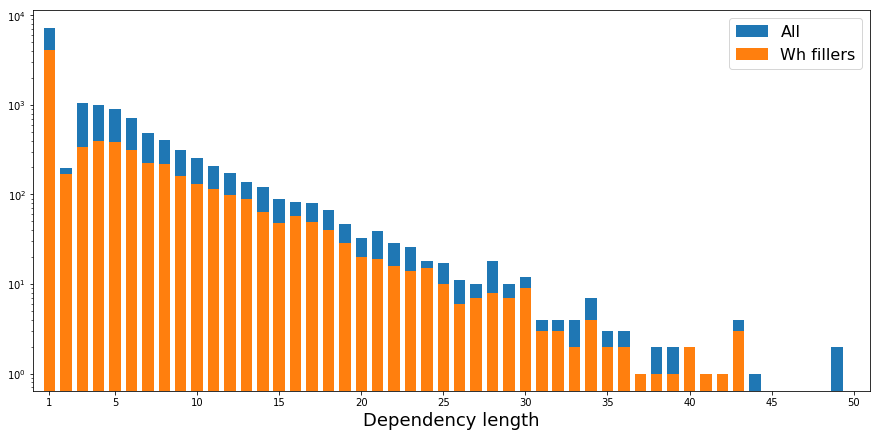

In [43]:
def plot_dep_lens(gapsendict, label=''):
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['axes.axisbelow'] = True

    dep_lens = [g.dep_len for g in gapsendict.values()]
    plt.hist(dep_lens, bins=(np.arange(max(dep_lens)) - 0.5), rwidth=0.7, label=label)
    plt.yscale('log')
    plt.grid()
    plt.xlim((0,51))
    plt.xticks([1] + list(range(5,51,5)))
    plt.xlabel('Dependency length', fontsize=18)
    
plot_dep_lens(gapsens, label='All')

wh_gaps = {k:g for k,g in gapsens.items() if g.filler[0] in 'Ww'}
plot_dep_lens(wh_gaps, label='Wh fillers')

plt.legend(prop={'size': 16})
plt.show()